In [12]:
# Adding the path of the agent's class as a system path
import sys
sys.path.append('../src')
import EV_Agent as ev_agent_py
import Line_Agent as line_agent_py

# Importing required libraries
import subprocess
import argparse
import math
import pandas as pd
from tqdm import tqdm
import pandapower as pp
from pandapower.plotting.plotly import pf_res_plotly
from pandapower.plotting.plotly import simple_plotly
from pandapower.plotting import simple_plot
import time
import numpy as np
import matplotlib.pyplot as plt
import pandapower.networks as nw
from pandapower.plotting import simple_plot, simple_plotly
from scipy import signal
from itertools import chain
from statistics import mean
import math
import random
from functools import reduce
from scipy import signal, spatial
from scipy.stats import norm
import time
from tqdm import tqdm


## IEEE LVTF Network
### Constructing IEEE network using PandaPower

In [13]:
# Path to the folder with network data
args = {'csv_path': r'../data/network/European_LV_CSV_simplified/'}

In [14]:
args.update({'nb_sub_districts': 1})  #Number of Sub-Districts (Default 1)
args.update({'unbalanced': False}) #Unbalanced or Balanced Network (Default False)
args.update({'draw': False}) #Draw network or not
args.update({'nb_districts': 1}) #Number of Districts (Default 1)
args.update({'output': "network.json"}) #Output format of the network

In [15]:
#Initializations of coordinates to draw(plot) the network
h_step = 200
v_step_2 = 200
v_step = v_step_2 * args['nb_sub_districts']

# geodata limits from ELVTF
x_min = 390868.753
y_min = 392747.256

# Import ELVTF dataframes
buses = pd.read_csv(args['csv_path'] + "Buscoords.csv", header=1)
lines = pd.read_csv(args['csv_path'] +"Lines.csv", header=1)
loads = pd.read_csv(args['csv_path'] + "Loads.csv", header=2)

In [16]:
# There battery storage in PandaPower does not include SoC and SoH variables etc. Defining a method to modify the PandaPower storage type to include these variables
# soc_percent = SoC value
# soh_percent = SoH value
# eff_chrg = efficiency charging
# eff_dischrg = efficiency discharging
# n_cycles = total number of cycles of the battery
# dod = depth of discharge
def create_storage_pp(net, name, bus, p_mw=0.0, max_e_mwh=0.03, soc_percent=0.5, soh_percent=0.5, eff_chrg = 0.96, eff_dischrg = 0.95,
                      n_cycles=14000, dod=0.4):
    pp.create_storage(net, bus, p_mw = p_mw, max_e_mwh = max_e_mwh, soc_percent = soc_percent, name = name);
    net.storage['soh_percent'] = soh_percent;
    net.storage['eff_chrg'] = eff_chrg;
    net.storage['eff_dischrg'] = eff_dischrg;
    net.storage['n_cycles'] = n_cycles;
    net.storage['dod'] = dod;

In [17]:
# Defining loads in the network based on the network type.
# If the network is unbalanced, loads are attached based on the phase data
# If the network is balanced, loads are attached without any phase consideration
if args['unbalanced']:
    def create_load_from_row(row):
        P = 0
        S = P / 0.95
        Q = math.sqrt(S**2 - P**2)
        bus = pp.get_element_index(net, "bus","bus_ELVTF_" + str(row["Bus"]) + "_" + str(i) + "_" + str(j))
        if row["phases"] == "A":
            pp.create_asymmetric_load(net, bus=bus, p_a_mw=P, q_a_mvar=Q, name=row["Name"])
        elif row["phases"] == "B":
            pp.create_asymmetric_load(net, bus=bus, p_b_mw=P, q_b_mvar=Q, name=row["Name"])
        elif row["phases"] == "C":
            pp.create_asymmetric_load(net, bus=bus, p_c_mw=P, q_c_mvar=Q, name=row["Name"])
        else:
            print("ERROR: unkown phase")
else:
    def create_load_from_row(row):
        P = 2 * 1e-3
        S = P / 0.95
        Q = math.sqrt(S**2- P**2)
        # Creating loads
        pp.create_load(net, bus=pp.get_element_index(net, "bus","bus_ELVTF_" + str(row["Bus"]) + "_" + str(i) + "_" + str(j)),
                       p_mw=P, q_mvar=Q, name=row["Name"])
        # Creating PV generators at the load buses
        #pp.create_sgen(net, bus=pp.get_element_index(net, "bus","bus_ELVTF_" + str(row["Bus"]) + "_" + str(i) + "_" + str(j)),
        #	p_mw=0.00, q_mvar=0, name=row["Name"])
        # Creating EV battery storage at the load buses
        create_storage_pp(net, name="EV" + row["Name"][4:], bus=pp.get_element_index(net, "bus","bus_ELVTF_" + str(row["Bus"]) + "_" + str(i) + "_" + str(j)),
                          p_mw=0.0, max_e_mwh=30.0,soc_percent=0.3, soh_percent=0.9, eff_chrg = 0.96, eff_dischrg = 0.95, n_cycles=14000, dod=0.4 )

In [18]:
# Defining a method to create a line type from the input data
def create_line_type_from_row(row):
    dic = {
        "r_ohm_per_km": row["R1"],
        "x_ohm_per_km": row["X1"],
        "r0_ohm_per_km": row["R0"],
        "x0_ohm_per_km": row["X0"],
        "c_nf_per_km": row["C1"],
        "c0_nf_per_km": row["C0"],
        "max_i_ka": 1 # arbitrary value
    }
    pp.create_std_type(net, dic, row["Name"], element="line")

In [19]:
# Creating an empty network
net = pp.create_empty_network()
# Lines types
# from ELVTF
pd.read_csv(args['csv_path'] + "LineCodes.csv", header=1).apply(create_line_type_from_row, axis=1);

In [20]:
# Creating the required transformer type

dic = {
    "sn_mva": 0.8,
    "vn_hv_kv": 11,
    "vn_lv_kv": 0.416,
    "vk_percent": 4.01995,
    "vkr_percent": 0.4,
    "pfe_kw": 0,
    "i0_percent": 0,
    "shift_degree": 180,
    "vk0_percent": 6,
    "vkr0_percent": 1.30,
    "vector_group": 'Yyn',
    "mag0_percent": 100,
    "mag0_rx": 0,
    "si0_hv_partial": 0.9
}
pp.create_std_type(net, dic, "ELVTF", element="trafo")

In [21]:
# Populating the electrical network

i=1
j=1


# Ext Grid
pp.create_bus(net, vn_kv=11, name="bus_ext", geodata=(0,0))
pp.create_ext_grid(net, bus = pp.get_element_index(net,"bus", "bus_ext"), vm_pu = 1.01,
                   name = 'ext_grid', s_sc_max_mva=2286, rx_max=0.09, x0x_max=1, r0x0_max=0.09)
pp.create_sgen(net, bus=pp.get_element_index(net,"bus", "bus_ext"), p_mw=0.00, q_mvar=0, name='pv_ext')
# Buses ELVTF
buses.apply(lambda row:
            pp.create_bus(net, 0.416,
                          name="bus_ELVTF_" + str(int(row["Busname"])) + "_" + str(i) + "_" + str(j),
                          geodata=(7 * h_step + row[" x"] - x_min, v_step * i + v_step_2 * j + row[" y"] - y_min)), axis=1)
#Transformers T2
pp.create_transformer(net,
                      hv_bus = pp.get_element_index(net, "bus","bus_ext"),
                      lv_bus=pp.get_element_index(net, "bus","bus_ELVTF_1_"  + str(i) + "_" + str(j)),
                      std_type='ELVTF',name="trafo")
# Lines ELVTF
lines.apply(lambda row:
            pp.create_line(net,
                           from_bus=pp.get_element_index(net, "bus","bus_ELVTF_" + str(row["Bus1"]) + "_" + str(i) + "_" + str(j)),
                           to_bus=pp.get_element_index(net, "bus","bus_ELVTF_" + str(row["Bus2"]) + "_" + str(i) + "_" + str(j)),
                           length_km=row["Length"]/1000.0, std_type=row["LineCode"], name=row["Name"]), axis=1)
# Loads ELVTF
loads.apply(create_load_from_row, axis=1);

In [22]:
# Customized run power flow method to incorporate customized battery storage method earlier
def runpp_pp(net, time_step = 1):
    # Running power flow
    pp.runpp(net);
    net.res_storage['soc_percent'] = 0.0000001;
    net.res_storage['soh_percent'] = 0.0000001;
    # Update SoC and SoH of each storage
    for i in range(0,len(net.storage)):
        soc_f = net.storage['soc_percent'][i] + ((((net.storage['p_mw'][i])*(time_step/3600)*net.storage['eff_chrg'][i])/net.storage['max_e_mwh'][i]) if (net.storage['p_mw'][i]>0) else (((net.storage['p_mw'][i])*(time_step/3600))/(net.storage['max_e_mwh'][i]*net.storage['eff_dischrg'][i])))
        soh_f = net.storage['soh_percent'][i] + (0 if (net.storage['p_mw'][i]>0) else (((net.storage['p_mw'][i])*(time_step/3600))/(0.2*net.storage['max_e_mwh'][i]*net.storage['eff_dischrg'][i]*net.storage['n_cycles'][i]*net.storage['dod'][i])))
        soc_f = min(max(0,soc_f),1)
        soh_f = min(max(0,soh_f),1)
        net.res_storage['soc_percent'].at[i] = soc_f;
        net.res_storage['soh_percent'].at[i] = soh_f;

# Assigning SoC and SoH results of this time step as the input of the next time step
def update_states(net):
    for i in range(0,len(net.storage)):
        net.storage['soc_percent'].at[i] = net.res_storage['soc_percent'][i]
        net.storage['soh_percent'].at[i] = net.res_storage['soh_percent'][i]

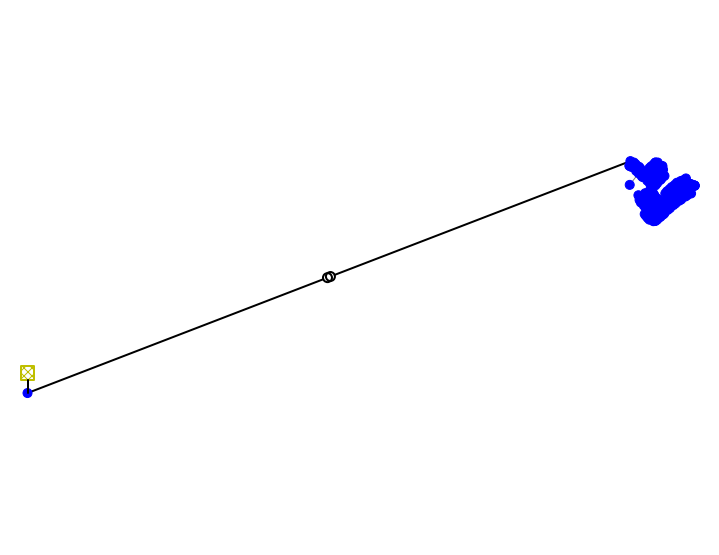

In [23]:
# Making a simple plot of the network
simple_plot(net, scale_size=True, ext_grid_size=1.0, trafo_size=1.0, bus_size=1.0);

# Input PV Data

## Load Data

In [24]:
load_active_power = np.zeros([len(net.load),1440])
load_reactive_power = np.zeros([len(net.load),1440])
for i in range(0,len(net.load)):
    load_profile_df = pd.read_csv(r'../data/loads/Load Profiles/Load_profile_' + str(i+1) + '.csv' , index_col=False)
    orignal_data_load = load_profile_df['mult'].values[0:1440]
    load_active_power[i] = np.array(orignal_data_load)
    load_reactive_power[i] = load_active_power[i]* math.tan(math.acos(0.95))

In [25]:
load_number = 54

fig, ax = plt.subplots(figsize=(18,5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'size': 15}
plt.rc('font', **font)
plt.plot(np.linspace(0,23,1*1440),load_active_power[load_number])
plt.plot(np.linspace(0,23,1*1440),load_reactive_power[load_number])
plt.xlabel('Hour of the day')
plt.ylabel('Power (kW)')
plt.xlim(0,23)
plt.legend(['Active power', 'Reactive power'], fontsize=15, loc='upper left', ncol = 3, borderaxespad=0, frameon=False)
plt.grid(visible=None)
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1)

## PV Data

In [26]:
new_index1 = {} # Dictitonary to index dataframe
data1 = {}
year_last1 = int('2019')+1

y11 = '01/01/'+'2018'+' 00:00'
y21 = '31/12/'+'2018'+' 23:55'

new_index1.update({'2018': pd.date_range(y11,y21,freq='5T')}) # Create an index for the dataset


data_file1 = pd.read_csv(r'../data/solar/2018.csv',low_memory=False)
data_file1.columns = data_file1.iloc[1] # Change the columns name

# Extract important data for application, ie GHI :Gloal horizontal Iradiance
data_bis1 = pd.DataFrame(data=data_file1.iloc[2:,[7,10]])
data_bis1.index=new_index1['2018']

for elmm in data_bis1.columns:
    data_bis1[elmm] = np.array(data_bis1[elmm], dtype=float)

data1.update({'2018':data_bis1 })

In [38]:
# Making an array to store daily PV production data
solar_data1 = np.zeros([60,1440])
d = 0

for i in range(152,152+60):
    day_data_df1 = signal.resample(data1['2018']['GHI'][i*288:(i+1)*288].values,1440)
    solar_data1[d] = day_data_df1 * 0.00268784 * 10 * 10
    d = d+1

solar_data1[solar_data1<0] = 0
solar_mean1 = np.mean(solar_data1, axis=0)

## EV Data

In [28]:
evs_df = pd.read_csv(r'C:\Users\SATIE\Desktop\PC Transfer Data\EVs Data\ISGT\ev_data_55.csv' , index_col=False)
evs_df

t_arrive  t_depart(d+1)     soc_i  soc_f  chrg_req
0       1286            694  0.394787    0.8       191
1        650            550  0.525077    0.8       129
2       1069            411  0.629884    0.8        80
3       1330            438  0.663350    0.8        65
4        961             33  0.598379    0.8        95
5       1195            111  0.660859    0.8        66
6       1098            204  0.461991    0.8       159
7       1262            862  0.304665    0.8       233
8        290            190  0.304665    0.8       233
9       1369           1047  0.304665    0.8       233
10      1271            795  0.385685    0.8       195
11      1229            391  0.463963    0.8       158
12      1266            788  0.304665    0.8       233
13      1078            799  0.695144    0.8        50
14       772            418  0.574861    0.8       106
15      1063            963  0.326390    0.8       223
16      1286            363  0.612916    0.8        88
17      1177           1113  0.304665    0.8       233
18      1173           1096  0.610828    0.8        89
19      1160            583  0.650910    0.8        70
20      1359            467  0.304665    0.8       233
21      1141           1031  0.306427    0.8       232
22      1277            280  0.304665    0.8       233
23      1151            301  0.669483    0.8        62
24      1327            183  0.602647    0.8        93
25      1316            421  0.452135    0.8       164
26      1372            590  0.545337    0.8       120
27      1380             61  0.702044    0.8        46
28      1209           1177  0.694178    0.8        50
29      1270            251  0.610598    0.8        89
30      1296            222  0.392270    0.8       192
31      1422            501  0.336580    0.8       218
32      1303            631  0.408363    0.8       184
33      1182           1023  0.355699    0.8       209
34      1147            691  0.304598    0.8       233
35      1049            312  0.588300    0.8       100
36       835            102  0.304665    0.8       233
37      1299            600  0.304665    0.8       233
38      1106            249  0.476788    0.8       152
39       742            642  0.480577    0.8       150
40       879            531  0.624710    0.8        83
41      1157            755  0.497892    0.8       142
42      1217           1122  0.630243    0.8        80
43      1268            815  0.660069    0.8        66
44       797            787  0.304665    0.8       233
45      1124            656  0.631246    0.8        80
46      1210            868  0.304665    0.8       233
47      1294            344  0.714681    0.8        41
48      1182           1131  0.424256    0.8       177
49      1183            753  0.466203    0.8       157
50      1129            716  0.304665    0.8       233
51      1252            645  0.571658    0.8       108
52       756            350  0.640702    0.8        75
53      1156           1136  0.616806    0.8        86
54      1314            410  0.609323    0.8        90

In [29]:
ev_slots = np.linspace(evs_df['t_arrive'][0] , 1440+evs_df['t_depart(d+1)'][0], (1440-evs_df['t_arrive'][0]) + evs_df['t_depart(d+1)'][0]+1)%1440

evs_p = np.zeros(1440)
for t in range(0,1440):
    for e in range(0,len(net.storage)):
        ev_slots = np.linspace(evs_df['t_arrive'][e] , 1440+evs_df['t_depart(d+1)'][e], (1440-evs_df['t_arrive'][e]) + evs_df['t_depart(d+1)'][e]+1)%1440
        if(t in ev_slots):
          evs_p[t] = evs_p[t] + 1

## Electricity Price

In [30]:
#Electricity price data
electricity_price = np.loadtxt(r'../data/electricity price/electricity price.csv', delimiter=",")
price_array_simple = electricity_price
#Orignal electricity price (non-normalized)
electricity_price_original = np.loadtxt(r'../data/electricity price/electricity_price_original.csv', delimiter=",")

# Simulation
## CMAB (without PV) estimation

In [39]:
days = 60  #Total number of simulation days
p_max = 7  #Max charging power of EV agent (in kW)
e_bat = 54  #Battery capacity of EV agent (in kWh)
bat_eff = 0.95 #Charging/discharging efficiency of the battery
daily_decision_instants  = 1440 #Number of decision instants in a day
congestion_limit = 0.25 #in kA

In [40]:
ev_agents_index  = np.ndarray((len(net.storage)),dtype=object)
for e in range(0,len(net.storage)):
    ev_agents_index[e] = ev_agent_py.EV_Agent(net.storage['name'][e],evs_df['t_arrive'][e],evs_df['t_depart(d+1)'][e],
                            evs_df['chrg_req'][e],1,price_array_simple,100,0* solar_data1[29]/24)


In [41]:
line_agent = line_agent_py.Line_Agent('Line 0', congestion_limit, price_array_simple, 10)

In [42]:
# Making lists and arrays to store the required results
ext_grid_p_npv = []
ext_grid_q_npv = []
line_current_npv = []
avg_rewards_npv = np.zeros((len(net.storage),days*daily_decision_instants))
reward_hist_npv = np.zeros((len(net.storage),days*daily_decision_instants))
voltage_npv = []
trfo_p_npv = []

# Running Simulation
for t in tqdm(range(0,days*daily_decision_instants)):

    minute_of_day = t%1440
    hour = int(math.ceil((minute_of_day+1)/60))-1
    # Select actions at the start of the day
    if (minute_of_day == 0):
        for a in range(0,len(ev_agents_index)):
            ev_agents_index[a].select_actions()
    # Setting active and reactive powers of the loads and the generators
    for l in range(0,len(net.load)):
        net.load['p_mw'][l] = load_active_power[l][minute_of_day]/1000
        net.load['q_mvar'][l] = load_reactive_power[l][minute_of_day]/1000
        net.sgen['p_mw'][l] = solar_data1[int(np.floor(t/daily_decision_instants))][minute_of_day]/1000
    # Setting active powers of each EV agent
    for l in range(0,len(net.storage)):
        if(minute_of_day in ev_agents_index[l].selected_actions):
            net.storage['p_mw'][l] = (p_max/1000)
        elif (minute_of_day in np.where(ev_agents_index[l].solar_estimate>=0.2)[0]):
            net.storage['p_mw'][l] = (ev_agents_index[l].solar_estimate[minute_of_day]/1000)
        else:
            net.storage['p_mw'][l] = 0

    # Running Power Flow and storing results
    runpp_pp(net, time_step = 60)
    update_states(net)
    ext_grid_p_npv.append(net.res_ext_grid['p_mw'][0])
    ext_grid_q_npv.append(net.res_ext_grid['q_mvar'][0])
    line_current_npv.append(net.res_line['i_ka'][0])
    voltage_npv.append(net.res_bus['vm_pu'][205])
    trfo_p_npv.append(net.res_trafo['p_lv_mw'][0])
    # Recording instataneous voltage value for each bus
    for l in range(0,len(net.storage)):
        ev_agents_index[l].inst_voltage = net.res_bus['vm_pu'][net.storage['bus'][l]]

    # Bandit Algorithm
    line_agent.reward_evs(minute_of_day, net.res_line['i_ka'][0], ev_agents_index)

    # Storing average instataneous average rewards
    for e in range(0,len(net.storage)):
        avg_rewards_npv[e][t] = avg_rewards_npv[e][t-1] + (ev_agents_index[e].get_avg_reward() - avg_rewards_npv[e][t-1])/(t+1)
        reward_hist_npv[e][t] = (ev_agents_index[e].get_avg_reward())

100%|██████████| 86400/86400 [1:40:23<00:00, 14.34it/s]


In [141]:
plt.plot(-np.array(trfo_p_npv[59*1440:]))

## Results Analysis

In [67]:
# Plotting average learning reward (mean reward of the running average of the reward of all EVs)
avg_rewards_final_npv = []
for r in avg_rewards_npv:
    if (str(r[0]) != 'nan'):
        avg_rewards_final_npv.append(r)
plt.figure(figsize=(18, 4), dpi=100, facecolor='w', edgecolor='k')
for i in range(0, 1):
    plt.plot(np.linspace(0, days, days*daily_decision_instants), (np.mean(np.array(avg_rewards_final_npv[i*55:(i+1)*55]), axis = 0) - min(np.mean(np.array(avg_rewards_final_npv[i*55:(i+1)*55]), axis = 0))) / (max(np.mean(np.array(avg_rewards_final_npv[i*55:(i+1)*55]), axis = 0)) - min(np.mean(np.array(avg_rewards_final_npv[i*55:(i+1)*55]), axis = 0))), alpha = 1, linewidth=3.0)
plt.xlabel('Day')
plt.ylabel('Avg. Reward')
plt.title('Avg Reward')
plt.xticks([i for i in range(0, days,5)]);
plt.ylim(0,1)
plt.xlim(1, days);

In [70]:
# Plotting line current on a specific day
selected_day = 60

plt.figure(figsize=(18,3), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(np.linspace(0,23,daily_decision_instants),np.array(line_current_npv)[(selected_day-1)*1440:(selected_day)*1440])
plt.xlabel('Hour of the day')
plt.axhline(y=0.251, color='r', linestyle='--', lw=2)
plt.legend(['Line Current', 'Rated Current'])
plt.ylabel('Line Current (kA)')
plt.title('Line Current')
plt.xlim(0,23)
plt.xticks([i for i in range(0,23)]);
plt.ylim(0,0.5);

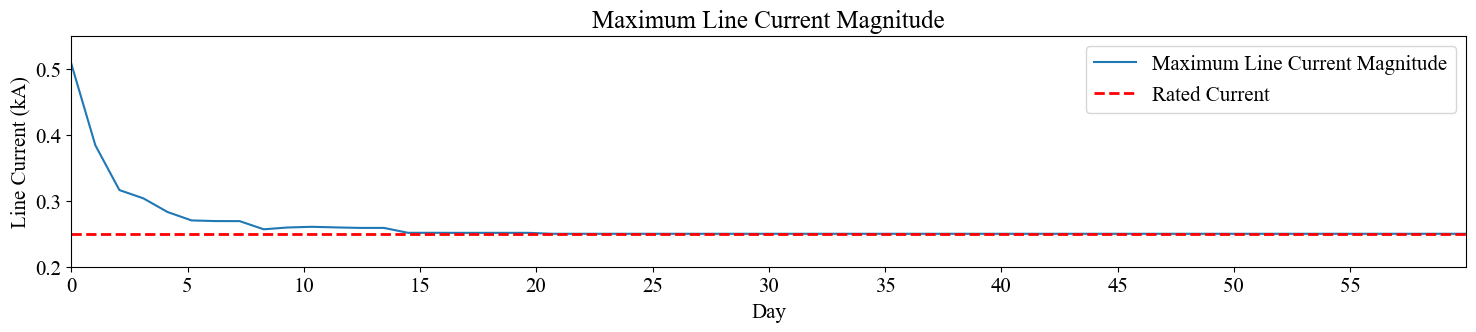

In [118]:
# Plotting maximum current magnitude during each simulation day
daily_current_max = []
for dd in range(1,days):
    daily_current_max.append(max(np.array(line_current_npv)[(dd-1)*1440:dd*1440]))

plt.figure(figsize=(18,3), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(np.linspace(0, days, days-1),daily_current_max)
plt.xlabel('Day')
plt.axhline(y=0.25, color='r', linestyle='--', lw=2)
plt.legend(['Maximum Line Current Magnitude', 'Rated Current'])
plt.ylabel('Line Current (kA)')
plt.title('Maximum Line Current Magnitude')
plt.xlim(0,days)
plt.xticks([i for i in range(0,days,5)]);
plt.ylim(0.2,0.55);

In [119]:
plt.figure(figsize=(18,3), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
# matplotlib histogram
plt.hist(line_current_npv[:30*1440], color = 'blue', edgecolor = 'black',bins = 24);
plt.axvline(x=0.25, color='r', linestyle='--')
plt.title('Frequency distribution of the line current (training)');
plt.xlabel('Line current (kA)');
plt.ylabel('Number of instants');
plt.xlim(0,0.5);


plt.subplot(1,2,2)
# matplotlib histogram
plt.hist(line_current_npv[30*1440:], color = 'blue', edgecolor = 'black',bins = 12);
plt.axvline(x=0.25, color='r', linestyle='--')
plt.title('Frequency distribution of the line current (evaluation)');
plt.xlabel('Line current (kA)');
plt.ylabel('Number of instants');
plt.xlim(0,0.5);

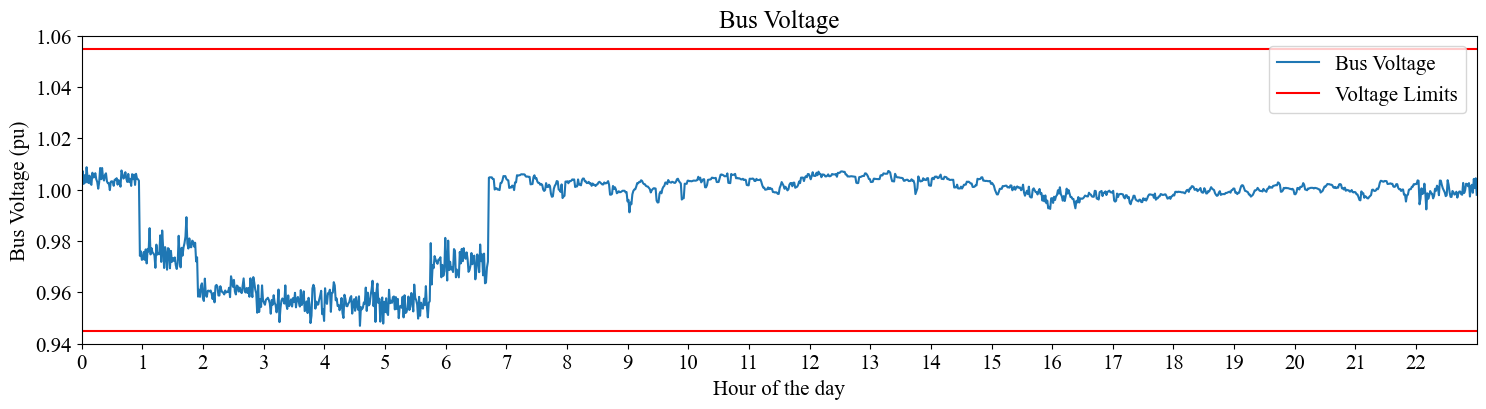

In [87]:
# Plotting voltage results on a specific day
selected_day = 60

plt.figure(figsize=(18,4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(np.linspace(0,23,1*daily_decision_instants),np.array(voltage_npv)[(selected_day-1)*1440:(selected_day)*1440])
plt.xlabel('Hour of the day')
plt.axhline(y=1.055, color='r', linestyle='-')
plt.axhline(y=0.945, color='r', linestyle='-')
plt.legend(['Bus Voltage', 'Voltage Limits'])
plt.ylabel('Bus Voltage (pu)')
plt.title('Bus Voltage')
plt.xlim(0,23)
plt.xticks([i for i in range(0,23)]);
plt.ylim(0.94,1.06);

In [120]:
plt.figure(figsize=(18,3), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
# matplotlib histogram
plt.hist(voltage_npv[:30*1440], color = 'blue', edgecolor = 'black',bins = 24);
plt.axvline(x=0.945, color='r', linestyle='--')
plt.axvline(x=1.055, color='r', linestyle='--')
plt.title('Frequency distribution of the bus voltage (training)');
plt.xlabel('Voltage (pu)');
plt.ylabel('Number of instants');
plt.xlim(0.94,1.06);

plt.subplot(1,2,2)
# matplotlib histogram
plt.hist(voltage_npv[30*1440:], color = 'blue', edgecolor = 'black',bins = 12);
plt.axvline(x=0.945, color='r', linestyle='--')
plt.axvline(x=1.055, color='r', linestyle='--')
plt.title('Frequency distribution of the bus voltage (evaluation)');
plt.xlabel('Voltage (pu)');
plt.ylabel('Number of instants');
plt.xlim(0.94,1.06);

In [137]:
# Calculating total cost on a given day

sig_ev_demand = np.zeros((55,1440))
grid_charging_sig = np.zeros((55,1440))
solar_day = 58
daily_price_hist_sig = []


for l in range(0,len(net.storage)):
    for t in range(0,1440):
        if(t in ev_agents_index[l].selected_actions):
            sig_ev_demand[l][t] = 7
        else:
            sig_ev_demand[l][t] = 0


print("Total charging cost on the selected day is:", np.sum(np.maximum(np.sum(sig_ev_demand,axis =0) - solar_data1[solar_day],0) * electricity_price_original))

Total charging cost on the selected day is: 3862.3575130636336
